In [62]:
# basic python libs
import re
from collections import Counter

# Data analysis libs
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ML and NLP libs
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Project libraries
# set path to local modules and submodules
import sys, os
sys.path.append(os.path.abspath("src")) # add src folder to path
# import local modules and submodules
from data_ravers_utils.file_handler import read_df_pickle, save_df_pickle, PROJECT_ROOT
import data_ravers_utils.eda_utils as eda

# Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

# Logging
import logging
# setup logging level
logging.getLogger().setLevel(logging.INFO)

# Exploratory Data Analysis (EDA)

In [31]:
df_filename = 'df_training_data_v0'

data = read_df_pickle(df_filename)
df = data.copy()
df.head(5)

,label,text
0,1,"Cuando conocí a Janice en 2013 , una familia n..."
1,0,Hwang habló en Sur de este año por Southwest M...
2,1,Usted podría pensar Katy Perry y Robert Pattin...
3,1,Cualquiera que haya volado los cielos del crea...
4,1,"Bueno , este cantante tendrá un LARGO tiempo p..."


# Assessing data integrity

In [9]:
eda.auto_cleanup(df)

INFO:root:Number of rows before cleanup: 14924
INFO:root:Dataset has no empty spaces.
INFO:root:Dataset has no duplicates.
INFO:root:Number of rows after cleanup: 14924


In [10]:
df_nulls = eda.count_nulls(df)
print(df_nulls)

       is_na  not_na  na_percent na_percent_pretty
label      0   14924         0.0             0.00%
text       0   14924         0.0             0.00%


## Analysing data types and unique values

In [11]:
from IPython.utils.capture import capture_output

# this code will be captured in memory and not displayed
with capture_output() as output:
    eda.print_eda_report(df)

In [12]:
print(output.stdout)

report_path = f'{PROJECT_ROOT}/docs/auto_eda_raw_report.md'

with open(report_path, "w") as f:
    f.write(output.stdout)

print(f"Output has been saved to file:\n{report_path}")

================= Dataset =================
Dataset has shape (14924, 2)

Dataset has numerical data in columns: ['label']
- Column "label" has 2 unique values.
  -- Unique values are:
 [1 0]

Dataset has categorical data in columns: ['text']
- Column "text" has 14924 unique values.


Output has been saved to file:
/Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/mini_projects/project-3-nlp/docs/auto_eda_raw_report.md


## Frequency table

In [14]:
frequency_table = eda.get_frequency_table(df, column='label')
print(frequency_table)
print()

   label  count
0      0   7464
1      1   7460



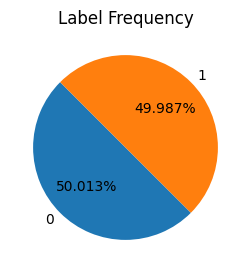

In [24]:
# Calculate the frequency of each media_type
label_counts = df["label"].value_counts()

# Create a donut chart
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.3f%%', startangle=135, wedgeprops={'width': 1})
plt.title("Label Frequency")
plt.show()

## Explore stylistic and linguistic differences

In [32]:
# target sample size per class
N_PER_CLASS = 200
RANDOM_SEED = 42  # reproducibility

# stratified sampling: same number of rows per label
df_slice = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=N_PER_CLASS, random_state=RANDOM_SEED))
      .reset_index(drop=True)
)

print(df_slice.shape)
df_slice["label"].value_counts()

(400, 2)


label
0    200
1    200
Name: count, dtype: int64

## Sentence length

       count    mean  median        std  min  max
label                                            
0        200  36.295    23.0  74.084415    5  851
1        200  26.795    22.0  26.758232    5  262


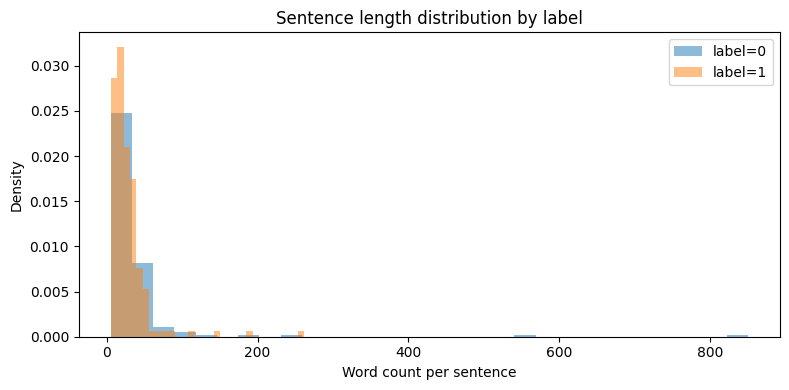

In [33]:
# assume df_slice with columns: "text" (str), "label" (0 = machine, 1 = human)

# --- word count per sentence ---
df_slice = df_slice.copy()
df_slice["word_count"] = df_slice["text"].str.split().str.len()

# --- mean / median word counts per label ---
length_stats = (
    df_slice
    .groupby("label")["word_count"]
    .agg(["count", "mean", "median", "std", "min", "max"])
)
print(length_stats)

# --- histograms of sentence length per label ---
fig, ax = plt.subplots(figsize=(8, 4))

for lbl, subset in df_slice.groupby("label"):
    ax.hist(
        subset["word_count"],
        bins=30,
        alpha=0.5,
        label=f"label={lbl}",
        density=True,
    )

ax.set_xlabel("Word count per sentence")
ax.set_ylabel("Density")
ax.set_title("Sentence length distribution by label")
ax.legend()
plt.tight_layout()
plt.show()

### Observations
- Remarkable outliers for machine translation. Probably due to randomness of data slice values.

## Character-level patterns

In [36]:
# Helper for safe counting (works even if text is NaN)
def count_pattern(text, pattern):
    if not isinstance(text, str):
        return 0
    return len(re.findall(pattern, text))

# Define patterns for Spanish/Latin punctuation
PUNCT_PATTERNS = {
    "num_commas": r",",
    "num_periods": r"\.",
    "num_semicolons": r";",
    "num_colons": r":",
    "num_qmarks": r"\?|¿",          # both ? and ¿
    "num_emarks": r"!|¡",           # both ! and ¡
    "num_ellipses": r"\.{3,}",      # sequences of 3+ dots
    "num_dashes": r"—|–|-",         # em dash, en dash, hyphen
    "num_quotes": r"['\"“”‘’«»]",   # all typical quote types
    "num_parens": r"[()]",          # parentheses
}

# Apply all at once (vectorized comprehension)
for col, pattern in PUNCT_PATTERNS.items():
    df_slice[col] = df_slice["text"].apply(lambda s: count_pattern(s, pattern))

# Optional: total punctuation count
df_slice["num_punct_total"] = df_slice[list(PUNCT_PATTERNS.keys())].sum(axis=1)

# Quick sanity check
print(df_slice[list(PUNCT_PATTERNS.keys())].head())

   num_commas  num_periods  num_semicolons  num_colons  num_qmarks  \
0           0            1               0           1           0   
1           2            1               0           0           0   
2           0            2               0           0           0   
3           1            1               0           0           0   
4           0            0               0           0           0   

   num_emarks  num_ellipses  num_dashes  num_quotes  num_parens  
0           0             0           1           0           0  
1           0             0           1           0           0  
2           0             0           0           0           0  
3           0             0           1           0           0  
4           0             0           0           0           0  


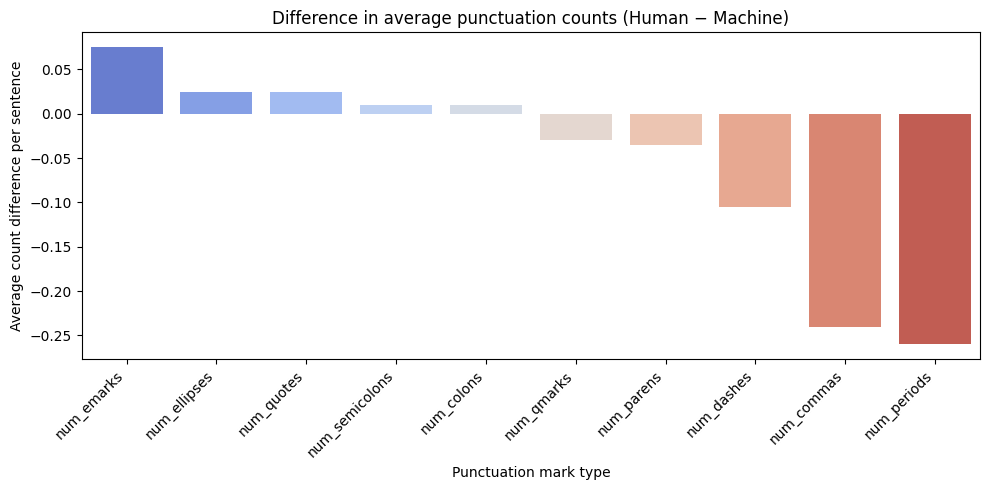

In [39]:
# visualize punktuation marks distribution

# List punctuation columns (reuse from previous step)
punct_cols = list(PUNCT_PATTERNS.keys())

# Compute mean punctuation counts per label
punct_means = (
    df_slice.groupby("label")[punct_cols]
    .mean()
    .T
    .rename(columns={0: "Machine (0)", 1: "Human (1)"})
)

# Sort by average difference for visual clarity
punct_means["diff"] = punct_means["Human (1)"] - punct_means["Machine (0)"]
punct_means = punct_means.sort_values("diff", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.barplot(
    data=punct_means.reset_index(),
    x="index",
    y="diff",
    palette="coolwarm",
)
plt.title("Difference in average punctuation counts (Human − Machine)")
plt.ylabel("Average count difference per sentence")
plt.xlabel("Punctuation mark type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


-	Bars above zero → punctuation used more frequently by human translators.
-	Bars below zero → punctuation used more frequently by machine translations.

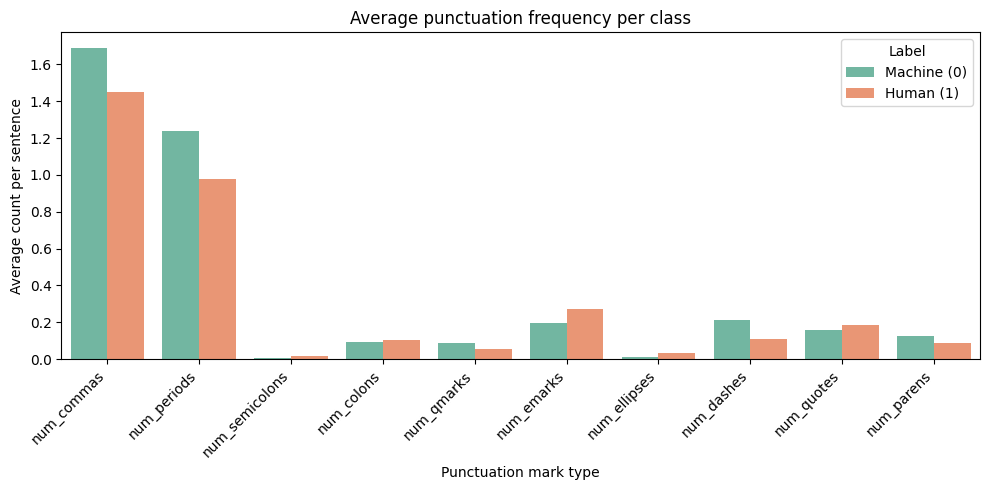

In [41]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=punct_means_long,
    x="punct",
    y="mean_count",
    hue="label",
    palette="Set2"
)

plt.title("Average punctuation frequency per class")
plt.ylabel("Average count per sentence")
plt.xlabel("Punctuation mark type")
plt.xticks(rotation=45, ha="right")

# --- Corrected legend ---
# get current handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
# replace labels but keep the color handles
ax.legend(handles=handles,
          labels=["Machine (0)", "Human (1)"],
          title="Label")

plt.tight_layout()
plt.show()

### Observations:
- Humans use exclamation marks more frequently.
- Machines know where to put commas better, than humans.

## Word-level patterns

In [ ]:
# use spaCy's built-in Spanish stopwords
SPANISH_STOPWORDS = nlp_es.Defaults.stop_words


# ---------- Tokenization helpers ----------

def iter_spacy_tokens(text: str, use_lemma: bool = False):
    """
    Yield cleaned tokens from a Spanish text using spaCy:
    - skip spaces & punctuation
    - optionally use lemmas instead of surface forms
    """
    if not isinstance(text, str):
        return
    doc = nlp_es(text)
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        yield tok.lemma_.lower() if use_lemma else tok.lower_


# ---------- Stopword frequency by class ----------

def top_stopwords_for_label(df_subset, top_n: int = 20, use_lemma: bool = False):
    tokens = []
    # use nlp.pipe for efficiency on a batch of texts
    for doc in nlp_es.pipe(df_subset["text"].astype(str).tolist(), batch_size=64):
        for tok in doc:
            if tok.is_space or tok.is_punct:
                continue
            t = tok.lemma_.lower() if use_lemma else tok.lower_
            if t in SPANISH_STOPWORDS:
                tokens.append(t)

    return Counter(tokens).most_common(top_n)


for lbl in sorted(df_slice["label"].unique()):
    print(f"\nTop stopwords for label={lbl}:")
    subset = df_slice[df_slice["label"] == lbl]
    for w, c in top_stopwords_for_label(subset, top_n=20, use_lemma=False):
        print(f"{w:>10} : {c}")


Top stopwords for label=0:
        de : 486
        la : 226
       que : 212
        en : 203
        el : 158
         y : 142
         a : 132
        un : 97
       los : 83
      para : 81
       una : 76
        se : 74
        su : 71
        es : 66
       con : 56
       por : 51
        no : 49
       más : 48
        lo : 46
      como : 40

Top stopwords for label=1:
        de : 289
       que : 166
        en : 133
        la : 121
         y : 112
        el : 110
         a : 96
       una : 72
        un : 66
       los : 61
        no : 59
      para : 58
       por : 50
       con : 50
        es : 48
        su : 47
        se : 44
        lo : 37
       del : 34
      como : 34


In [56]:
# custom analyzer for CountVectorizer using spaCy tokens
def spacy_analyzer(text: str):
    # change use_lemma=True if you want lemma-based n-grams
    return list(iter_spacy_tokens(text, use_lemma=False))


def top_ngrams(df_subset, ngram_range=(1, 3), top_n: int = 20):
    vec = CountVectorizer(
        analyzer=spacy_analyzer,
        ngram_range=ngram_range,
        max_features=None,
    )
    X = vec.fit_transform(df_subset["text"].astype(str))
    freqs = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    counts = list(zip(vocab, freqs))
    counts.sort(key=lambda x: x[1], reverse=True)
    return counts[:top_n]


for lbl in sorted(df_slice["label"].unique()):
    print(f"\nTop 1–3-grams for label={lbl}:")
    subset = df_slice[df_slice["label"] == lbl]
    for phrase, freq in top_ngrams(subset, (1, 3), top_n=20):
        print(f"{phrase:30} {int(freq)}")


Top 1–3-grams for label=0:
de                             486
la                             226
que                            212
en                             203
el                             158
y                              142
a                              132
un                             97
los                            83
para                           81
una                            76
se                             74
su                             71
es                             66
1                              57
con                            56
por                            51
no                             49
más                            48
lo                             46

Top 1–3-grams for label=1:
de                             289
que                            166
en                             133
la                             121
y                              112
el                             110
a                              96
una          

### Observations

## Language-specific quirks

In [57]:
# basic analysis

df_slice = df_slice.copy()

# flag multiple spaces and odd spacing before punctuation
df_slice["has_double_space"] = df_slice["text"].str.contains(r"  +", regex=True)
df_slice["space_before_punct"] = df_slice["text"].str.contains(r"\s+[,.!?;:]", regex=True)

# flag sentences containing "strange" characters (non-ASCII, which might hint at encoding issues)
df_slice["has_non_ascii"] = df_slice["text"].apply(lambda s: any(ord(ch) > 127 for ch in s))

# inspect a few "suspicious" sentences per label
suspicious = df_slice[
    df_slice["has_double_space"]
    | df_slice["space_before_punct"]
    | df_slice["has_non_ascii"]
]

print(f"Suspicious sentences (first 10 out of total {suspicious.shape[0]} cases):")
display(
    suspicious[["label", "text", "has_double_space", "space_before_punct", "has_non_ascii"]]
    .head(10)
)

Suspicious sentences (first 10 out of total 394 cases):


,label,text,has_double_space,space_before_punct,has_non_ascii
0,0,Sobre el hombre-Boy : Peter Pans son sólo dive...,False,True,True
1,0,Este paseo es la historia lección reveladora p...,False,True,True
2,0,Una moneda digital que cambiará consumidor viv...,False,True,True
3,0,Aunque sin duda es posible que existan otras f...,False,True,False
5,0,Se calcula tomando el número total de miembros...,False,True,True
6,0,Cher Lloyd nos dio un fin de semana fantástico...,False,True,True
8,0,Esas dos piezas de la Federación han estado en...,False,True,True
9,0,Yo sé que una vez que la pantalla completa un ...,False,True,True
10,0,Detesto el agua de coco y cuando me hizo vomit...,False,True,True
11,0,Me llama la atención por la fe absoluta de Kra...,False,True,True


In [58]:
# SpaCy approach

def add_spacy_quirk_features(
    df: pd.DataFrame,
    text_col: str = "text",
    nlp = nlp_es,
) -> pd.DataFrame:
    """
    Add language-specific 'quirk' features using spaCy:
    - sentence count, avg sentence length
    - POS composition (verbs, adjectives, pronouns, adverbs)
    - OOV / 'unknown' tokens ratio
    - proportion of tokens with POS == 'X' (often foreign/strange)
    - named entity counts
    """
    texts = df[text_col].astype(str).tolist()
    records = []

    for doc in nlp.pipe(texts, batch_size=64):
        tokens = [t for t in doc if not t.is_space]
        n_tokens = len(tokens) if tokens else 1  # avoid division by zero

        sents = list(doc.sents)
        n_sents = len(sents) if sents else 1

        # POS counts
        num_verbs = sum(t.pos_ == "VERB" for t in tokens)
        num_adjs  = sum(t.pos_ == "ADJ"  for t in tokens)
        num_advs  = sum(t.pos_ == "ADV"  for t in tokens)
        num_pron  = sum(t.pos_ == "PRON" for t in tokens)
        num_x_pos = sum(t.pos_ == "X"    for t in tokens)  # spaCy uses 'X' for other/unknown

        # OOV / unknown tokens (often untranslated names, English words, gibberish)
        num_oov = sum(t.is_oov for t in tokens)

        # Named entities
        ents = list(doc.ents)
        num_ents = len(ents)
        num_ent_person = sum(ent.label_ == "PER" for ent in ents)
        num_ent_org    = sum(ent.label_ == "ORG" for ent in ents)
        num_ent_loc    = sum(ent.label_ in {"LOC", "GPE"} for ent in ents)

        records.append({
            "num_sents": n_sents,
            "avg_tokens_per_sent": n_tokens / n_sents,

            "verb_ratio": num_verbs / n_tokens,
            "adj_ratio":  num_adjs  / n_tokens,
            "adv_ratio":  num_advs  / n_tokens,
            "pron_ratio": num_pron  / n_tokens,
            "x_pos_ratio": num_x_pos / n_tokens,

            "oov_ratio":  num_oov / n_tokens,

            "num_ents": num_ents,
            "num_ent_person": num_ent_person,
            "num_ent_org":    num_ent_org,
            "num_ent_loc":    num_ent_loc,
        })

    feat_df = pd.DataFrame(records, index=df.index)
    return df.join(feat_df)


# apply to your sample (df_slice)
df_slice_spacy = add_spacy_quirk_features(df_slice, text_col="text")
df_slice_spacy.head()

,label,text,word_count,num_chars,num_commas,num_qmarks,num_emarks,num_ellipses,num_periods,num_semicolons,num_colons,num_dashes,num_quotes,num_parens,num_punct_total,has_double_space,space_before_punct,has_non_ascii,num_sents,avg_tokens_per_sent,verb_ratio,adj_ratio,adv_ratio,pron_ratio,x_pos_ratio,oov_ratio,num_ents,num_ent_person,num_ent_org,num_ent_loc
0,0,Sobre el hombre-Boy : Peter Pans son sólo dive...,10,53,0,0,0,0,1,0,1,1,0,0,3,False,True,True,1,10.0,0.000000,0.000000,0.100000,0.000000,0.0,1.0,2,1,0,0
1,0,Este paseo es la historia lección reveladora p...,23,148,2,0,0,0,1,0,0,1,0,0,4,False,True,True,1,23.0,0.043478,0.130435,0.000000,0.000000,0.0,1.0,0,0,0,0
2,0,Una moneda digital que cambiará consumidor viv...,14,79,0,0,0,0,2,0,0,0,0,0,2,False,True,True,1,14.0,0.142857,0.071429,0.071429,0.071429,0.0,1.0,2,0,0,0
3,0,Aunque sin duda es posible que existan otras f...,29,153,1,0,0,0,1,0,0,1,0,0,3,False,True,False,1,29.0,0.103448,0.034483,0.034483,0.137931,0.0,1.0,0,0,0,0
4,0,Los 4 chicos malos que necesita para romper Desde,9,49,0,0,0,0,0,0,0,0,0,0,0,False,False,False,2,4.5,0.222222,0.111111,0.000000,0.111111,0.0,1.0,0,0,0,0


In [60]:
quirk_cols = [
    "num_sents",
    "avg_tokens_per_sent",
    "verb_ratio",
    "adj_ratio",
    "adv_ratio",
    "pron_ratio",
    "x_pos_ratio",
    "oov_ratio",
    "num_ents",
    "num_ent_person",
    "num_ent_org",
    "num_ent_loc",
]

quirk_summary = (
    df_slice_spacy
    .groupby("label")[quirk_cols]
    .mean()
    .round(3)
)

print(quirk_summary)

       num_sents  avg_tokens_per_sent  verb_ratio  adj_ratio  adv_ratio  \
label                                                                     
0          1.435               25.024       0.089      0.059      0.048   
1          1.125               23.614       0.103      0.045      0.046   

       pron_ratio  x_pos_ratio  oov_ratio  num_ents  num_ent_person  \
label                                                                 
0           0.058          0.0        1.0     1.975           0.620   
1           0.065          0.0        1.0     1.335           0.485   

       num_ent_org  num_ent_loc  
label                            
0            0.225          0.5  
1            0.205          0.3  


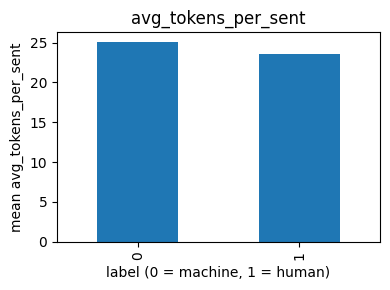

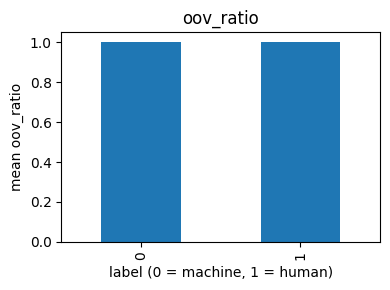

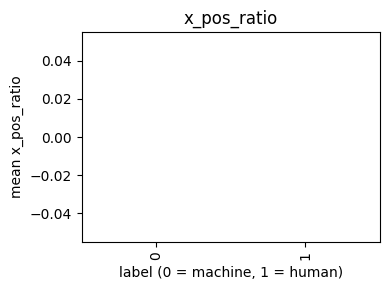

In [61]:
for col in ["avg_tokens_per_sent", "oov_ratio", "x_pos_ratio"]:
    ax = (
        df_slice_spacy
        .groupby("label")[col]
        .mean()
        .plot(kind="bar", figsize=(4, 3), title=col)
    )
    ax.set_xlabel("label (0 = machine, 1 = human)")
    ax.set_ylabel(f"mean {col}")
    plt.tight_layout()
    plt.show()

### Observations

# Backup checkpoint

In [28]:
df_filename = 'df_training_data_v1_clean'

save_df_pickle(df, df_filename)

INFO:root:Backup file is created: /Users/bubblegum_doubledrops/Library/Mobile Documents/com~apple~CloudDocs/0prio - Important heavy backups/IronHack/mini_projects/project-3-nlp/data/df_training_data_v1_clean.pkl
